<a href="https://colab.research.google.com/github/shayaf84/Detecting-Pneumonia-/blob/master/Detecting_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  


  

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D

import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16

from imgaug import augmenters 

 
### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1DNEiLAWguswhiLXGyVKsgHIRm1xZggt_'
metadata_url         = 'https://drive.google.com/uc?id=1MW3_FU6qc0qT_uG4bzxhtEHy4Jd6dCWb'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)



###
gdown.download(image_data_url, './image_data.npy', True)
gdown.download(metadata_url, './metadata.csv', True)

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)






In [ ]:
# get a table with information about ALL of our images
metadata = get_metadata()

# what does it look like?
metadata.head()

In [ ]:
# grab our seaborn visualization toolbox!
import seaborn as sns
### YOUR CODE HERE
print(metadata.groupby(["class"]).count())


sns.countplot(x ="class", data=metadata)

In [ ]:
### YOUR CODE HERE
print(metadata.groupby(["split"]).count())


sns.countplot(x ="split", data=metadata)
### END CODE

In [ ]:
### YOUR CODE HERE
print(metadata.groupby(["class","split"]).count())


sns.countplot(x ="class", data=metadata, hue = "split")
### END CODE

In [ ]:
def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

In [ ]:
train_data, train_labels = get_train_data()
image = train_data[0,:]
image_label = train_labels[0]

test_data, test_labels = get_test_data()


In [ ]:
plot_one_image(image)
plot_one_image(train_data,train_labels,1)

In [ ]:
### Here we load the train and test data for your to use.
(train_data, train_labels) = get_train_data(flatten = True)
(test_data, test_labels) = get_test_data(flatten = True)

### Use the models specified above to fit the function to your data
### E.g. knn = KNeighborsClassifier(n_neighbors = 5)
### Then follow the steps in Machine Learning! Fit, Predict, and Score

### YOUR CODE BELOW

knn  = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression()
tree  = DecisionTreeClassifier(max_depth = 1000)


knn.fit(train_data, train_labels)
log_reg.fit(train_data, train_labels)
tree.fit(train_data, train_labels)

predictions = knn.predict(test_data)
score = accuracy_score(test_labels, predictions)
print(score)

predictions = log_reg.predict(test_data)
score = accuracy_score(test_labels, predictions)
print(score)

predictions = tree.predict(test_data)
score = accuracy_score(test_labels, predictions)
print(score)

In [ ]:
 def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()
    print("The highest validation accuracy was",history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['val_accuracy'])
    print("The lowest validation accuracy was",history.sort_values(by = 'val_accuracy', ascending = True).iloc[0]['val_accuracy'])

In [ ]:
def plot_loss(history, ax = None, xlabel = 'Epoch #'):
    
    history = history.history
    history.update({'epoch':list(range(len(history['val_loss'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_loss', ascending = True).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_loss', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'loss', data = history, label = 'Training', ax = ax)
    
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.1, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss (Fraction)')
    
    plt.show()
    print("The lowest validation loss was",history.sort_values(by = 'val_loss', ascending = True).iloc[0]['val_loss'])
    print("The highest validation loss was",history.sort_values(by = 'val_loss', ascending = False).iloc[0]['val_loss'])

In [ ]:
def CNN():
  
  model = Sequential()
  model.add(Reshape((64,64,3)))
  model.add(Conv2D(32, (3, 3), padding = 'same',activation="relu",input_shape = (2000,64,64,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, (3, 3), padding = 'same',activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten()) 

  model.add(Dropout(0.5))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1, activation = 'sigmoid'))
  opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)

  model.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])    
  return model




In [ ]:
model = CNN()
monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(train_data, train_labels, epochs = 15, validation_data = (test_data, test_labels),callbacks=[monitor])
plot_acc(history)
plot_loss(history)

In [ ]:
expert_conv = VGG16(weights = 'imagenet', include_top = False,input_shape=(64,64,3))

for layer in expert_conv.layers:
      trainable = True
      layer.trainable = trainable


expert_model = Sequential()
expert_model.add(Reshape((64,64,3)))
expert_model.add(expert_conv)
expert_model.add(GlobalAveragePooling2D())

expert_model.add(Dense(128, activation = 'relu'))
expert_model.add(Dropout(0.3))
expert_model.add(Dense(64, activation = 'relu'))
expert_model.add(Dense(1, activation = "sigmoid"))

opt = keras.optimizers.SGD(lr=1e-4, momentum=0.95)

expert_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
history =expert_model.fit(train_data,train_labels,validation_data=(test_data,test_labels),epochs = 3)
plot_acc(history)
plot_loss(history)

In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()
field_data, field_labels = get_field_data()
  
average_accuracy = 0.0
for i in range(5):
  cnn_old = CNN()
  cnn_old.fit(train_data, train_labels, epochs = 15, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
  
  predictions = cnn_old.predict_classes(field_data)
  accuracy = accuracy_score(field_labels, predictions)
  print('Accuracy on this run:', accuracy)
  
  average_accuracy += accuracy / 5.0
print('Average accuracy: ', average_accuracy)
### END CODE

Label: 0.0


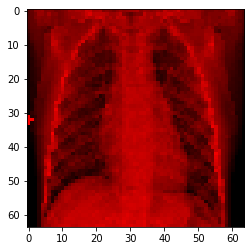

In [ ]:
plot_one_image(field_data,field_labels,40)

In [ ]:
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr(1)
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud(1)
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

In [ ]:
IMAGE_INDEX = 0
image = train_data[IMAGE_INDEX,:,:,:]
plot_one_image(shear(image, shear = 10))
plot_one_image(flip_left_right(image))
plot_one_image(flip_up_down(image))
plot_one_image(rotate(image, rotate = 90))
plot_one_image(remove_color(image, channel = 1))

In [ ]:
def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)
### Perform an augmentation.
train_data_rotated = rotate(train_data, rotate=90)
train_data_sheared = shear(train_data,shear=10)
train_data_left_right = flip_left_right(train_data)
train_data_up_down = flip_up_down(train_data)
train_data_color = remove_color(train_data,channel = 1)

### TODO: Perform one or more additional augmentations.



## Combine data. TODO: Add more data and corresponding labels here!
all_data, all_labels = combine_data([train_data, train_data_rotated,train_data_sheared,train_data_left_right,train_data_up_down,train_data_color], \
                                    [train_labels, train_labels,train_labels,train_labels,train_labels,train_labels])




### END CODE

In [ ]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels   = get_test_data()
field_data, field_labels   = get_field_data()

average_accuracy = 0.0

for i in range(5):
  cnn = CNN()
  cnn.fit(all_data, all_labels, epochs = 15, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
  predictions = cnn.predict_classes(field_data)
  accuracy = accuracy_score(field_labels, predictions)
  print('Accuracy:%0.2f'%accuracy)
  average_accuracy += accuracy

average_accuracy /= 5.0

print('Average accuracy: ', average_accuracy)
### END CODE